Goal of analysis script is to pull in excel files with manually entered intake, weight, and behavior data, ETA, and EDA


In [1]:
#getting and working with data
import pandas as pd
import scipy.stats as stats
import numpy as np
import re
import os
from tkinter import filedialog
from tkinter import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

In [2]:
root = Tk()
root.directory = filedialog.askdirectory()
print (root.directory)

C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice


In [3]:
path_names = []
files = os.listdir(root.directory)
for file in files: 
        path_names.append(root.directory + "/" + file)

path_names

['C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/622_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/623_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/624_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/625_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/626_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/627_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/628_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/629_1m.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/mice/630_1m.xlsx',
 'C:/Users/Schindler/Documents/Schind

In [4]:
group_path = "C:/Users/Schindler/Documents/Schindler_Lab/Data/Ethanol/Intermit 2BC/2BC 6dq r1 and 2/anymaze_data.xlsx"
data = pd.read_excel(group_path)
df_behavior = pd.DataFrame(data = data)
df_behavior.head()

,Animal,Cage_#,Treatment,Number,Group,Notes,wt_baseline,wt_blast,wt_72h,wt_28d,wt_blast_%,wt_72h_%,wt_28d_%,Distance_OFB_72,Speed_OFB_72,Center_time_OFB_72,Center_entries_OFB_72,Center_distance_OFB_72,Outside_time_OFB_72,Outside_entries_OFB_72,Outside_distance_OFB_72,Small_time_OFB_72,Small_entries_OFB_72,Small_distance_OFB_72,Distance_OFB_28,Speed_OFB_28,Center_time_OFB_28,Center_entries_OFB_28,Center_distance_OFB_28,Outside_time_OFB_28,Outside_entries_OFB_28,Outside_distance_OFB_28,Small_time_OFB_28,Small_entries_OFB_28,Small_distance_OFB_28,Distance_EZM_28,Speed_EZM_28,OA_entries_EZM_28,OA_time_EZM_28,OA_distance_EZM_28,CA_entries_EZM_28,CA_time_EZM_28,CA_distance_EZM_28
0,621,197,1,3,4,fighting,27.0,27.4,27.0,30.0,101.481481,100.000000,111.111111,35.488,0.118,62.3,24,9.284,237.7,24,26.204,8.2,9,1.047,9.567,0.032,23.1,7,2.373,276.9,8,7.193,2.7,4,0.487,2.188,0.007,7,88.4,0.482,7,211.6,1.706
1,622,197,1,3,4,fighting,25.6,25.7,25.9,28.0,100.390625,101.171875,109.375000,38.488,0.128,36.7,23,7.604,263.3,24,30.884,2.5,5,0.604,19.596,0.065,37.6,14,4.578,262.4,15,15.018,3.1,6,0.907,11.088,0.037,29,118.1,3.095,28,181.9,7.993
2,623,197,1,3,4,fighting,27.2,27.9,28.0,30.6,102.573529,102.941176,112.500000,28.815,0.096,62.9,19,7.292,237.0,18,21.523,6.5,10,1.206,17.954,0.060,34.5,14,3.855,265.5,15,14.099,1.9,2,0.278,8.304,0.028,24,90.5,2.641,24,209.5,5.662
3,624,198,2,3,5,NaN,27.3,25.3,26.7,29.2,92.673993,97.802198,106.959707,41.226,0.137,38.2,27,7.728,261.8,27,33.498,5.1,6,0.733,17.362,0.058,41.0,13,4.270,259.0,14,13.092,8.0,7,0.857,9.937,0.033,33,122.3,3.291,32,177.7,6.646
4,625,198,2,3,5,NaN,27.9,25.2,27.2,30.0,90.322581,97.491039,107.526882,32.112,0.107,56.1,27,8.169,243.9,27,23.943,8.2,9,1.063,24.151,0.081,47.2,21,5.890,252.8,22,18.260,5.1,6,0.860,10.478,0.035,23,98.2,2.805,23,201.8,7.673


In [5]:
df_behavior.groupby('Group').mean()

,Animal,Cage_#,Treatment,Number,wt_baseline,wt_blast,wt_72h,wt_28d,wt_blast_%,wt_72h_%,wt_28d_%,Distance_OFB_72,Speed_OFB_72,Center_time_OFB_72,Center_entries_OFB_72,Center_distance_OFB_72,Outside_time_OFB_72,Outside_entries_OFB_72,Outside_distance_OFB_72,Small_time_OFB_72,Small_entries_OFB_72,Small_distance_OFB_72,Distance_OFB_28,Speed_OFB_28,Center_time_OFB_28,Center_entries_OFB_28,Center_distance_OFB_28,Outside_time_OFB_28,Outside_entries_OFB_28,Outside_distance_OFB_28,Small_time_OFB_28,Small_entries_OFB_28,Small_distance_OFB_28,Distance_EZM_28,Speed_EZM_28,OA_entries_EZM_28,OA_time_EZM_28,OA_distance_EZM_28,CA_entries_EZM_28,CA_time_EZM_28,CA_distance_EZM_28
Group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,635.272727,201.454545,1.0,3.0,26.809091,26.863636,27.236364,29.227273,100.202272,101.606459,109.091601,31.737909,0.105636,47.954545,20.272727,7.041455,252.027273,20.272727,24.696455,7.181818,8.000000,1.030273,18.929636,0.063000,41.381818,14.545455,4.736727,258.618182,15.272727,14.192818,6.927273,6.181818,0.858273,7.408727,0.024636,20.181818,76.818182,1.530727,19.909091,223.181818,5.877909
5,640.750000,203.250000,2.0,3.0,28.116667,25.891667,27.575000,30.016667,92.116453,98.122101,106.948170,30.870417,0.102833,40.766667,19.916667,5.851000,259.225000,20.166667,25.019083,5.383333,5.583333,0.715167,20.989917,0.069917,44.183333,16.666667,4.919833,255.816667,17.166667,16.070333,6.900000,5.583333,0.816583,8.303333,0.027833,23.250000,90.608333,2.400333,23.000000,209.383333,5.903083


Loop through path names to create pandas data table from excel file. Get animal number from path name (animal number is file name), create array of animal number the length of the data_table and add this as a column.

In [6]:
data_start = pd.DataFrame()

for path in path_names:
    data_excel = pd.read_excel(path)
    data_table_int = pd.DataFrame(data = data_excel)
    
    name = path
    name = re.search("\d\d\d", path).group(0)
    name_long = [name] * len(data_table_int)
    
    group = df_behavior.loc[df_behavior['Animal'] == int(name), 'Group'].item()
    group_long = [group] * len(data_table_int)
    
    data_table_int = data_table_int.assign(Animal = name_long)
    data_table_int = data_table_int.assign(Group = group_long)  
    
    data_start = data_start.append(data_table_int, ignore_index=True)


data_start.head()

,Day,Day #,EtOH,Weight,EtOH bf,EtOH after,H2O b4,H2O after,H2O b4.1,H2O after.1,EtOH 8,H20 8,Animal,Group
0,Friday,1,0,28.5,x,x,85.6,79.6,88.6,85.3,x,x,622,4
1,Sunday,2,6,28.5,87,85.8,79.6,76.3,x,x,x,x,622,4
2,Monday,3,6,28.5,85.8,85,76.3,72.0,x,x,x,x,622,4
3,Tuesday,4,6,28.5,85,84,72.0,68.5,x,x,x,x,622,4
4,Wednesday,5,6,28.5,84,83,68.5,64.5,x,x,83.6,67.1,622,4


In [7]:
#replace x with 0
data_start.replace('x', 0, inplace=True)

In [8]:
def C2BC(data_start):
    "Analyzes two bottle choice data"
    
    #H20 24h data
    data_start['H2O_intake_1_raw'] = data_start['H2O b4'] - data_start['H2O after']
    
    data_start['H2O_intake_2_raw'] = data_start['H2O b4.1'] - data_start['H2O after.1']
    
    data_start['H2O_intake_raw'] = data_start['H2O_intake_1_raw'] + data_start['H2O_intake_2_raw']

    data_start['H2O_intake_24'] = data_start['H2O_intake_raw'] / (data_start['Weight'] /1000)
    
    #H20 8pm data
    if data_start['H20 8'] > 0:
        data_start['H2O_intake_raw_8'] = data_start['H2O b4'] - data_start['H20 8']

        data_start['H2O_intake_8'] = data_start['H2O_intake_raw_8'] / (data_start['Weight'] /1000)
    else:
        data_start['H2O_intake_raw_8'] = np.nan
        data_start['H2O_intake_8'] = np.nan

    #EtOH 24h data
    data_start['EtOH_intake_raw'] = data_start['EtOH bf'] - data_start['EtOH after']

    data_start['EtOH_intake_24'] = (data_start['EtOH_intake_raw'] * data_start['EtOH'] / 100) / (data_start['Weight'] /1000)

    #EtOH 8pm data
    if data_start['EtOH 8'] > 0:
        data_start['EtOH_intake_raw_8'] = data_start['EtOH bf'] - data_start['EtOH 8']

        data_start['EtOH_intake_8'] = (data_start['EtOH_intake_raw_8'] * data_start['EtOH'] / 100) / (data_start['Weight'] /1000)
    else:
        data_start['EtOH_intake_raw_8'] = np.nan
        data_start['EtOH_intake_8'] = np.nan
        
    #preference data
    data_start['EtOH_pref'] = data_start['EtOH_intake_raw'] / (data_start['EtOH_intake_raw'] + data_start['H2O_intake_raw'])

    if data_start['EtOH 8'] > 0:
        data_start['EtOH_pref_8'] = \
        data_start['EtOH_intake_raw_8'] / (data_start['EtOH_intake_raw_8'] + data_start['H2O_intake_raw_8'])
    else:
        data_start['EtOH_pref_8'] = np.nan
    
    return data_start

In [9]:
data_calc = data_start.apply(C2BC, axis = 1)
data_calc.head(9)

,Day,Day #,EtOH,Weight,EtOH bf,EtOH after,H2O b4,H2O after,H2O b4.1,H2O after.1,EtOH 8,H20 8,Animal,Group,H2O_intake_1_raw,H2O_intake_2_raw,H2O_intake_raw,H2O_intake_24,H2O_intake_raw_8,H2O_intake_8,EtOH_intake_raw,EtOH_intake_24,EtOH_intake_raw_8,EtOH_intake_8,EtOH_pref,EtOH_pref_8
0,Friday,1,0,28.5,0.0,0.0,85.6,79.6,88.6,85.3,0.0,0.0,622,4,6.0,3.3,9.3,326.315789,NaN,NaN,0.0,0.000000,NaN,NaN,0.000000,NaN
1,Sunday,2,6,28.5,87.0,85.8,79.6,76.3,0.0,0.0,0.0,0.0,622,4,3.3,0.0,3.3,115.789474,NaN,NaN,1.2,2.526316,NaN,NaN,0.266667,NaN
2,Monday,3,6,28.5,85.8,85.0,76.3,72.0,0.0,0.0,0.0,0.0,622,4,4.3,0.0,4.3,150.877193,NaN,NaN,0.8,1.684211,NaN,NaN,0.156863,NaN
3,Tuesday,4,6,28.5,85.0,84.0,72.0,68.5,0.0,0.0,0.0,0.0,622,4,3.5,0.0,3.5,122.807018,NaN,NaN,1.0,2.105263,NaN,NaN,0.222222,NaN
4,Wednesday,5,6,28.5,84.0,83.0,68.5,64.5,0.0,0.0,83.6,67.1,622,4,4.0,0.0,4.0,140.350877,1.4,49.122807,1.0,2.105263,0.4,0.842105,0.200000,0.222222
5,Thursday,6,6,28.5,83.0,82.4,64.5,61.0,0.0,0.0,0.0,0.0,622,4,3.5,0.0,3.5,122.807018,NaN,NaN,0.6,1.263158,NaN,NaN,0.146341,NaN
6,Friday,7,0,28.5,0.0,0.0,61.0,49.1,85.0,79.0,0.0,0.0,622,4,11.9,6.0,17.9,628.070175,NaN,NaN,0.0,0.000000,NaN,NaN,0.000000,NaN
7,Tuesday,11,6,28.5,82.0,81.0,49.1,44.6,0.0,0.0,0.0,0.0,622,4,4.5,0.0,4.5,157.894737,NaN,NaN,1.0,2.105263,NaN,NaN,0.181818,NaN
8,Wednesday,12,6,28.5,70.0,69.3,78.7,75.2,0.0,0.0,0.0,0.0,622,4,3.5,0.0,3.5,122.807018,NaN,NaN,0.7,1.473684,NaN,NaN,0.166667,NaN


In [10]:
#select relevant columns for further analysis
data_calc_only = data_calc[['Animal', 'Group', 'Day #', 'EtOH', 'H2O_intake_24', 'EtOH_intake_24', 'EtOH_pref']]
data_calc_only.head(9)

,Animal,Group,Day #,EtOH,H2O_intake_24,EtOH_intake_24,EtOH_pref
0,622,4,1,0,326.315789,0.000000,0.000000
1,622,4,2,6,115.789474,2.526316,0.266667
2,622,4,3,6,150.877193,1.684211,0.156863
3,622,4,4,6,122.807018,2.105263,0.222222
4,622,4,5,6,140.350877,2.105263,0.200000
5,622,4,6,6,122.807018,1.263158,0.146341
6,622,4,7,0,628.070175,0.000000,0.000000
7,622,4,11,6,157.894737,2.105263,0.181818
8,622,4,12,6,122.807018,1.473684,0.166667


In [11]:
#process etoh intake (ave over first six days), etoh deprivation (day 11), and quinine (day 12) data
EtOH_intake = data_calc_only.loc[(data_calc_only['Day #'] > 0) & (data_calc_only['Day #'] < 7)].groupby('Animal').mean()
EtOH_intake.columns = [str(col) + '_6dave' for col in EtOH_intake.columns]

EtOH_dep_intake = data_calc_only.loc[data_calc_only['Day #'] == 11].groupby('Animal').mean()
EtOH_dep_intake.columns = [str(col) + '_dep' for col in EtOH_dep_intake.columns]

EtOH_dep_intake['H2O_intake_dep_diff'] = (EtOH_dep_intake['H2O_intake_24_dep'] / EtOH_intake['H2O_intake_24_6dave']*100) - 100
EtOH_dep_intake['EtOH_intake_dep_diff'] = (EtOH_dep_intake['EtOH_intake_24_dep'] / EtOH_intake['EtOH_intake_24_6dave']*100) - 100
EtOH_dep_intake['EtOH_pref_dep_diff'] = (EtOH_dep_intake['EtOH_pref_dep'] / EtOH_intake['EtOH_pref_6dave']*100) - 100

EtOH_quinine_intake = data_calc_only.loc[data_calc_only['Day #'] == 12].groupby('Animal').mean()
EtOH_quinine_intake.columns = [str(col) + '_quin' for col in EtOH_quinine_intake.columns]

EtOH_quinine_intake['H2O_intake_quin_diff'] = (EtOH_quinine_intake['H2O_intake_24_quin'] / EtOH_intake['H2O_intake_24_6dave']*100) - 100
EtOH_quinine_intake['EtOH_intake_quin_diff'] = (EtOH_quinine_intake['EtOH_intake_24_quin'] / EtOH_intake['EtOH_intake_24_6dave']*100) - 100
EtOH_quinine_intake['EtOH_pref_quin_diff'] = (EtOH_quinine_intake['EtOH_pref_quin'] / EtOH_intake['EtOH_pref_6dave']*100) - 100

In [12]:
#process baseline H20 intake (Day_1) and 8pm data
data_H20_baseline = data_calc.loc[data_calc['Day #'] == 1].groupby('Animal').mean()
data_8pm = data_calc.loc[data_calc['H2O_intake_8'] > 0].groupby('Animal').mean()

In [13]:
#create final data table
EtOH_final = pd.DataFrame()
EtOH_final['Group'] = EtOH_intake['Group_6dave']
EtOH_final = pd.concat([EtOH_final, EtOH_intake.loc[:, 'H2O_intake_24_6dave':]], axis = 1)
EtOH_final = pd.concat([EtOH_final, EtOH_dep_intake.loc[:, 'H2O_intake_24_dep':]], axis = 1)
EtOH_final = pd.concat([EtOH_final, EtOH_quinine_intake.loc[:, 'H2O_intake_24_quin':]], axis = 1)
EtOH_final = pd.concat([EtOH_final, data_H20_baseline['H2O_intake_24']], axis = 1)
EtOH_final = pd.concat([EtOH_final, data_8pm.loc[:, ('H2O_intake_8', 'EtOH_intake_8', 'EtOH_pref_8')]], axis = 1)
EtOH_final.head()

,Group,H2O_intake_24_6dave,EtOH_intake_24_6dave,EtOH_pref_6dave,H2O_intake_24_dep,EtOH_intake_24_dep,EtOH_pref_dep,H2O_intake_dep_diff,EtOH_intake_dep_diff,EtOH_pref_dep_diff,H2O_intake_24_quin,EtOH_intake_24_quin,EtOH_pref_quin,H2O_intake_quin_diff,EtOH_intake_quin_diff,EtOH_pref_quin_diff,H2O_intake_24,H2O_intake_8,EtOH_intake_8,EtOH_pref_8
Animal,,,,,,,,,,,,,,,,,,,,
622,4.0,163.157895,1.614035,0.165349,157.894737,2.105263,0.181818,-3.225806,30.434783,9.960355,122.807018,1.473684,0.166667,-24.731183,-8.695652,0.796992,326.315789,49.122807,0.842105,0.222222
623,4.0,133.116883,2.370130,0.273888,58.441558,6.233766,0.640000,-56.097561,163.013699,133.672358,120.129870,1.558442,0.177778,-9.756098,-34.246575,-35.091012,314.935065,22.727273,0.584416,0.300000
624,5.0,150.574713,2.517241,0.255268,113.793103,5.379310,0.440678,-24.427481,113.698630,72.633510,0.000000,2.275862,1.000000,-100.000000,-9.589041,291.745272,331.034483,27.586207,1.034483,0.384615
625,5.0,147.777778,3.000000,0.315961,66.666667,8.800000,0.687500,-54.887218,193.333333,117.590396,140.000000,1.600000,0.160000,-5.263158,-46.666667,-49.360780,393.333333,30.000000,0.800000,0.307692
626,5.0,139.455782,3.333333,0.406644,51.020408,6.938776,0.693878,-63.414634,108.163265,70.635078,115.646259,1.632653,0.190476,-17.073171,-51.020408,-53.158998,489.795918,10.204082,1.428571,0.700000


In [14]:
#create final data table that includes behavior also
final_data = EtOH_final[['Group', 'H2O_intake_24', 'H2O_intake_24_6dave', 'EtOH_intake_24_6dave', 'EtOH_pref_6dave', 'H2O_intake_8', 'EtOH_intake_8', 'EtOH_pref_8', 'H2O_intake_dep_diff', 'EtOH_intake_dep_diff', 'EtOH_pref_dep_diff', 'H2O_intake_quin_diff', 'EtOH_intake_quin_diff', 'EtOH_pref_quin_diff']]
final_data.reset_index(inplace=True)
#exclude animals 621 and 632 (no data for etoh exp)
df_behavior_etoh_only = df_behavior[(df_behavior['Animal'] != 621) & (df_behavior['Animal'] != 632)]
df_behavior_etoh_only.reset_index(inplace=True)
final_data = pd.concat([final_data, df_behavior_etoh_only.loc[:, 'wt_blast_%':]], axis = 1, join="inner")
final_data.to_csv('final_data.csv')

In [15]:
#prepare data table to process for outliers
final_data.set_index(['Animal', 'Group'], inplace=True)
#create new data frame organized by group so we can compute outliers for each group individually
data_groups = final_data.unstack(level = -1)
#compute quartiles, IQRs, and bounds for each parameter for each group
quartile_1 = data_groups.quantile(0.25)
quartile_3 = data_groups.quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
#use bounds to exclude any data points outside of the bounds (outliers will be replaced with NaN)
outliers = data_groups[(data_groups <= upper_bound) & (data_groups >= lower_bound)]
#stack to return dataframe to original orientation
final_data_no_outliers = outliers.stack()
final_data_no_outliers.to_csv('final_data_no_outliers.csv')

In [16]:
final_data_no_outliers.groupby('Group').mean()

,H2O_intake_24,H2O_intake_24_6dave,EtOH_intake_24_6dave,EtOH_pref_6dave,H2O_intake_8,EtOH_intake_8,EtOH_pref_8,H2O_intake_dep_diff,EtOH_intake_dep_diff,EtOH_pref_dep_diff,H2O_intake_quin_diff,EtOH_intake_quin_diff,EtOH_pref_quin_diff,wt_blast_%,wt_72h_%,wt_28d_%,Distance_OFB_72,Speed_OFB_72,Center_time_OFB_72,Center_entries_OFB_72,Center_distance_OFB_72,Outside_time_OFB_72,Outside_entries_OFB_72,Outside_distance_OFB_72,Small_time_OFB_72,Small_entries_OFB_72,Small_distance_OFB_72,Distance_OFB_28,Speed_OFB_28,Center_time_OFB_28,Center_entries_OFB_28,Center_distance_OFB_28,Outside_time_OFB_28,Outside_entries_OFB_28,Outside_distance_OFB_28,Small_time_OFB_28,Small_entries_OFB_28,Small_distance_OFB_28,Distance_EZM_28,Speed_EZM_28,OA_entries_EZM_28,OA_time_EZM_28,OA_distance_EZM_28,CA_entries_EZM_28,CA_time_EZM_28,CA_distance_EZM_28
Group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.0,347.274094,118.189518,3.826650,0.453750,19.094903,1.733346,0.552457,-49.268931,54.824410,28.116421,-1.361858,-42.712176,-48.345711,100.074351,101.767105,108.889650,33.468,0.111444,46.520000,20.375000,6.959125,253.46,21.555556,24.545700,5.433333,6.333333,0.769222,17.476250,0.058125,34.200000,13.777778,4.321444,265.800000,14.444444,13.950429,7.350000,5.000000,0.711778,7.930800,0.0264,21.500000,75.66,1.6356,21.200000,224.340000,5.522333
5.0,403.005193,139.286300,3.719787,0.365712,23.805624,1.585467,0.558091,-58.587792,78.135416,50.487196,-17.988163,-53.209349,-47.506713,91.501531,96.896264,105.813583,31.428,0.104727,41.088889,20.090909,6.444000,258.90,20.363636,25.536273,4.850000,5.818182,0.749364,20.492636,0.068273,44.636364,16.636364,4.867727,255.363636,17.090909,15.625091,6.963636,5.363636,0.793000,8.057636,0.0270,22.363636,86.80,2.1830,22.090909,213.190909,5.874727


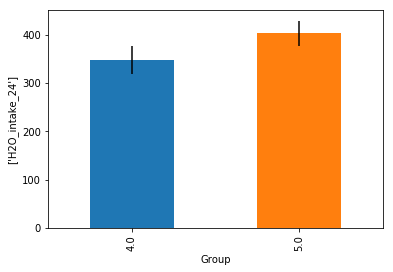

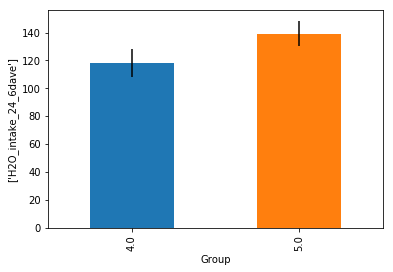

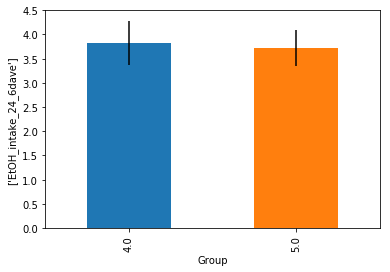

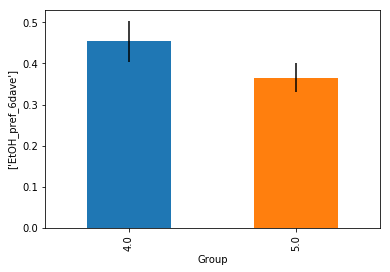

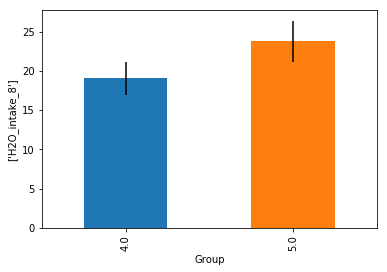

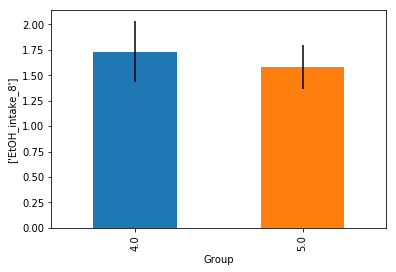

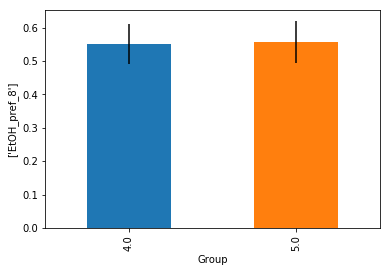

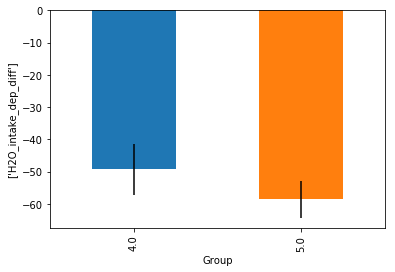

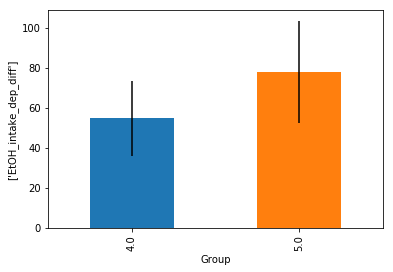

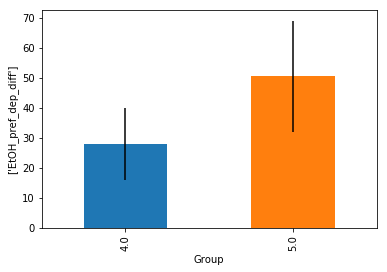

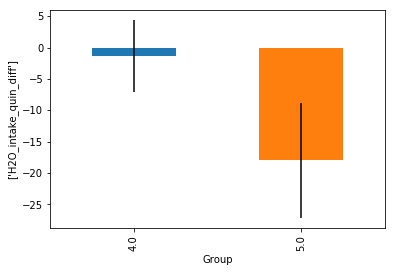

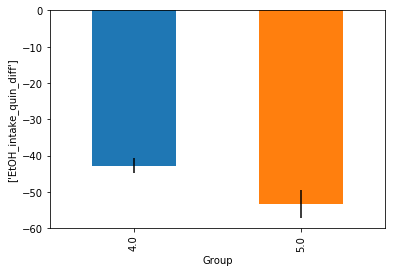

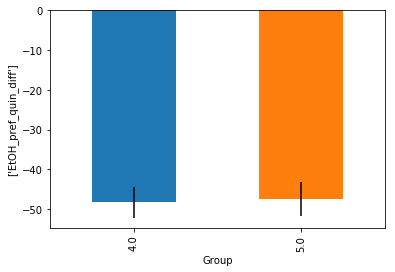

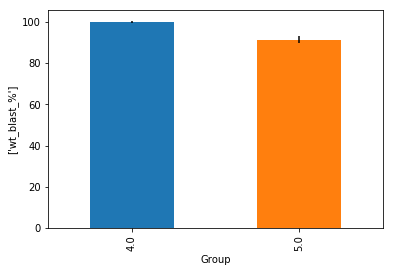

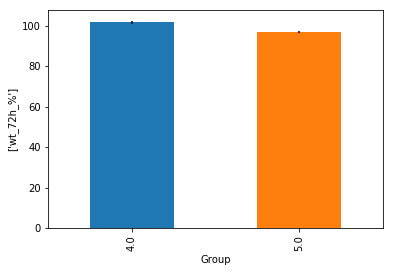

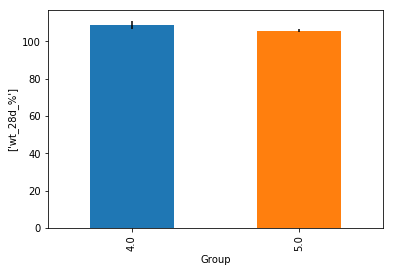

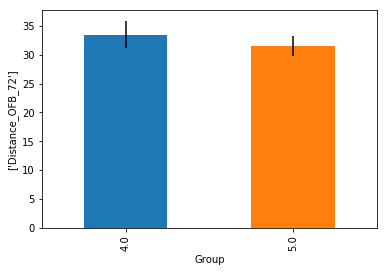

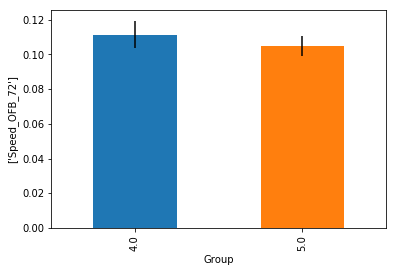

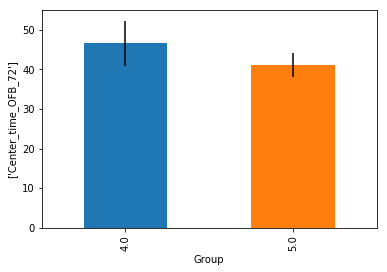

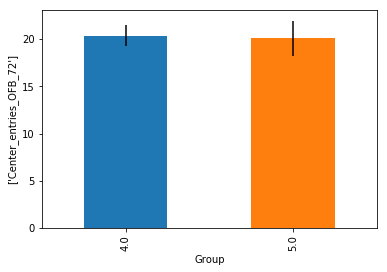

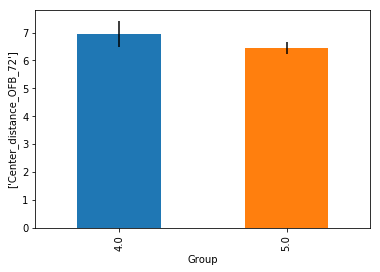

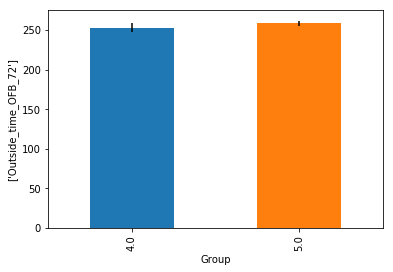

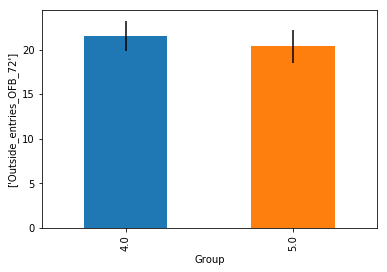

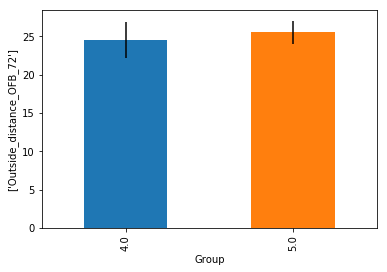

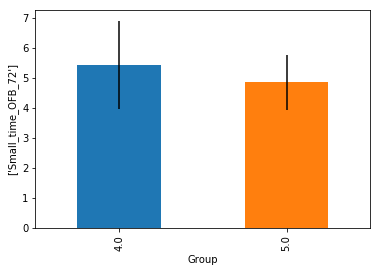

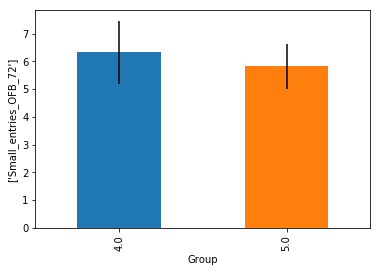

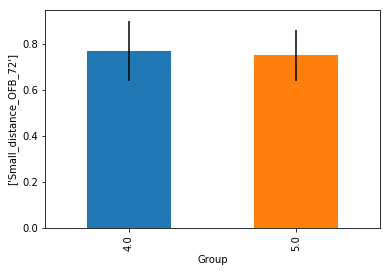

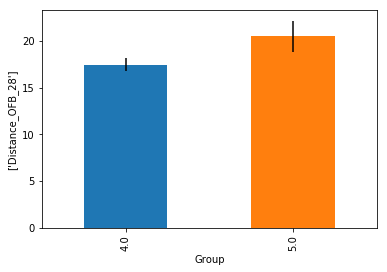

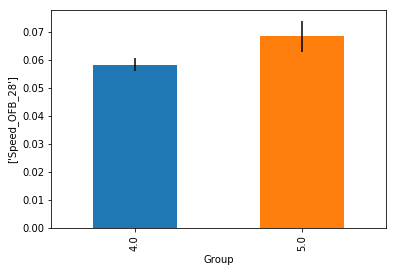

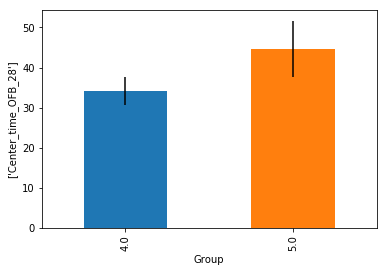

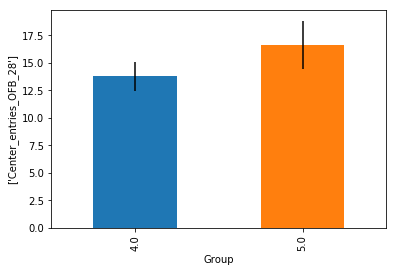

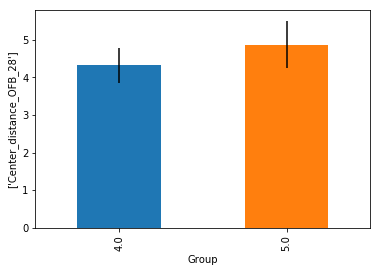

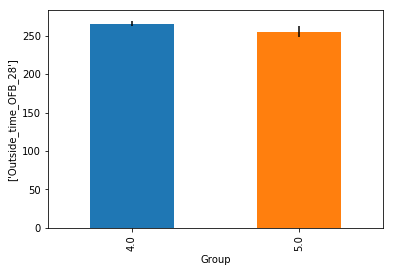

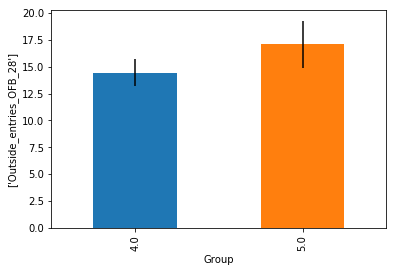

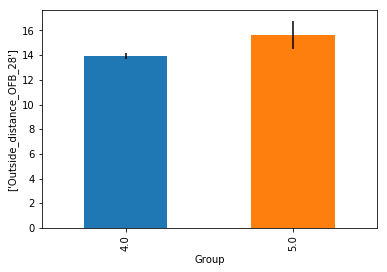

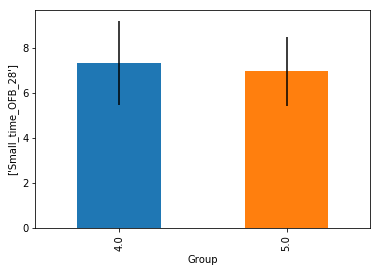

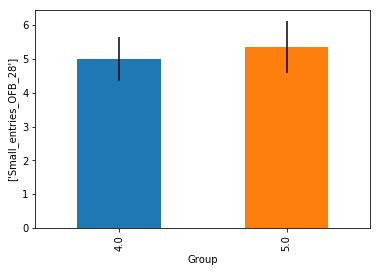

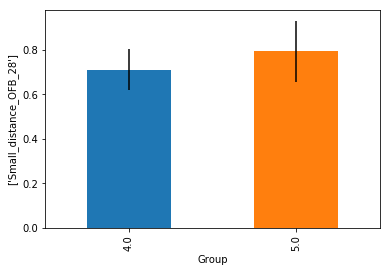

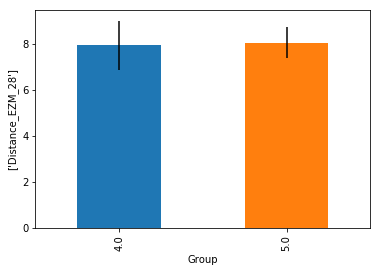

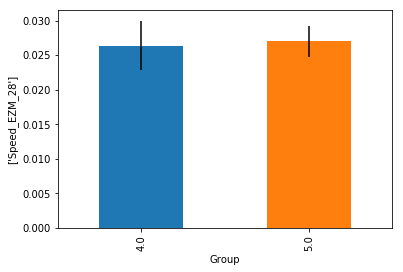

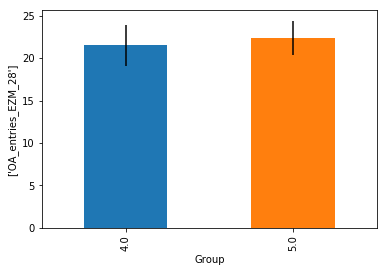

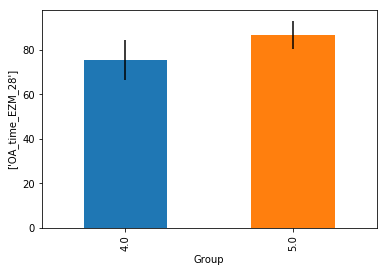

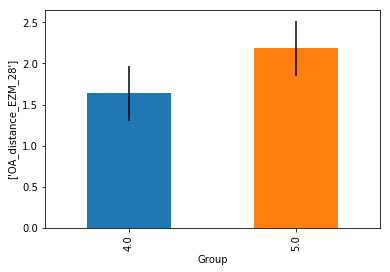

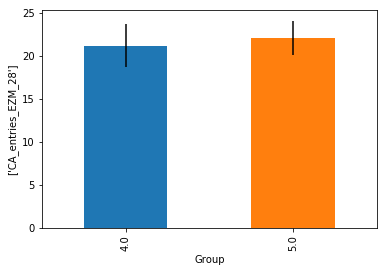

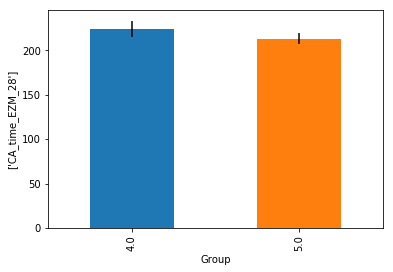

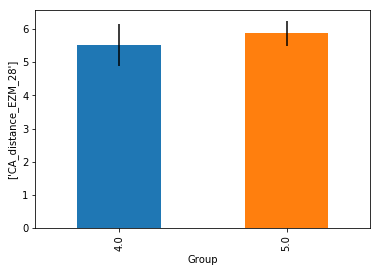

In [17]:
param_names = list(final_data_no_outliers)

for param in param_names:
    final_data_no_outliers.groupby("Group")[param].mean().plot(kind='bar', yerr=final_data_no_outliers.groupby("Group")[param].sem())
    plt.ylabel([param])
    plt.show()

In [18]:
#select variables for pariwise viz
behav_vars = ['wt_blast_%', 'Distance_OFB_72', 'Speed_OFB_72', 'Center_time_OFB_72', 'Distance_OFB_28', 'Speed_OFB_28', 'Center_time_OFB_28', 'OA_time_EZM_28', 'OA_distance_EZM_28']
etoh_vars = ['H2O_intake_24', 'H2O_intake_24_6dave', 'EtOH_intake_24_6dave', 'EtOH_pref_6dave', 'H2O_intake_8', 'EtOH_intake_8', 'EtOH_pref_8', 'H2O_intake_dep_diff', 'EtOH_intake_dep_diff', 'EtOH_pref_dep_diff', 'H2O_intake_quin_diff', 'EtOH_intake_quin_diff', 'EtOH_pref_quin_diff']

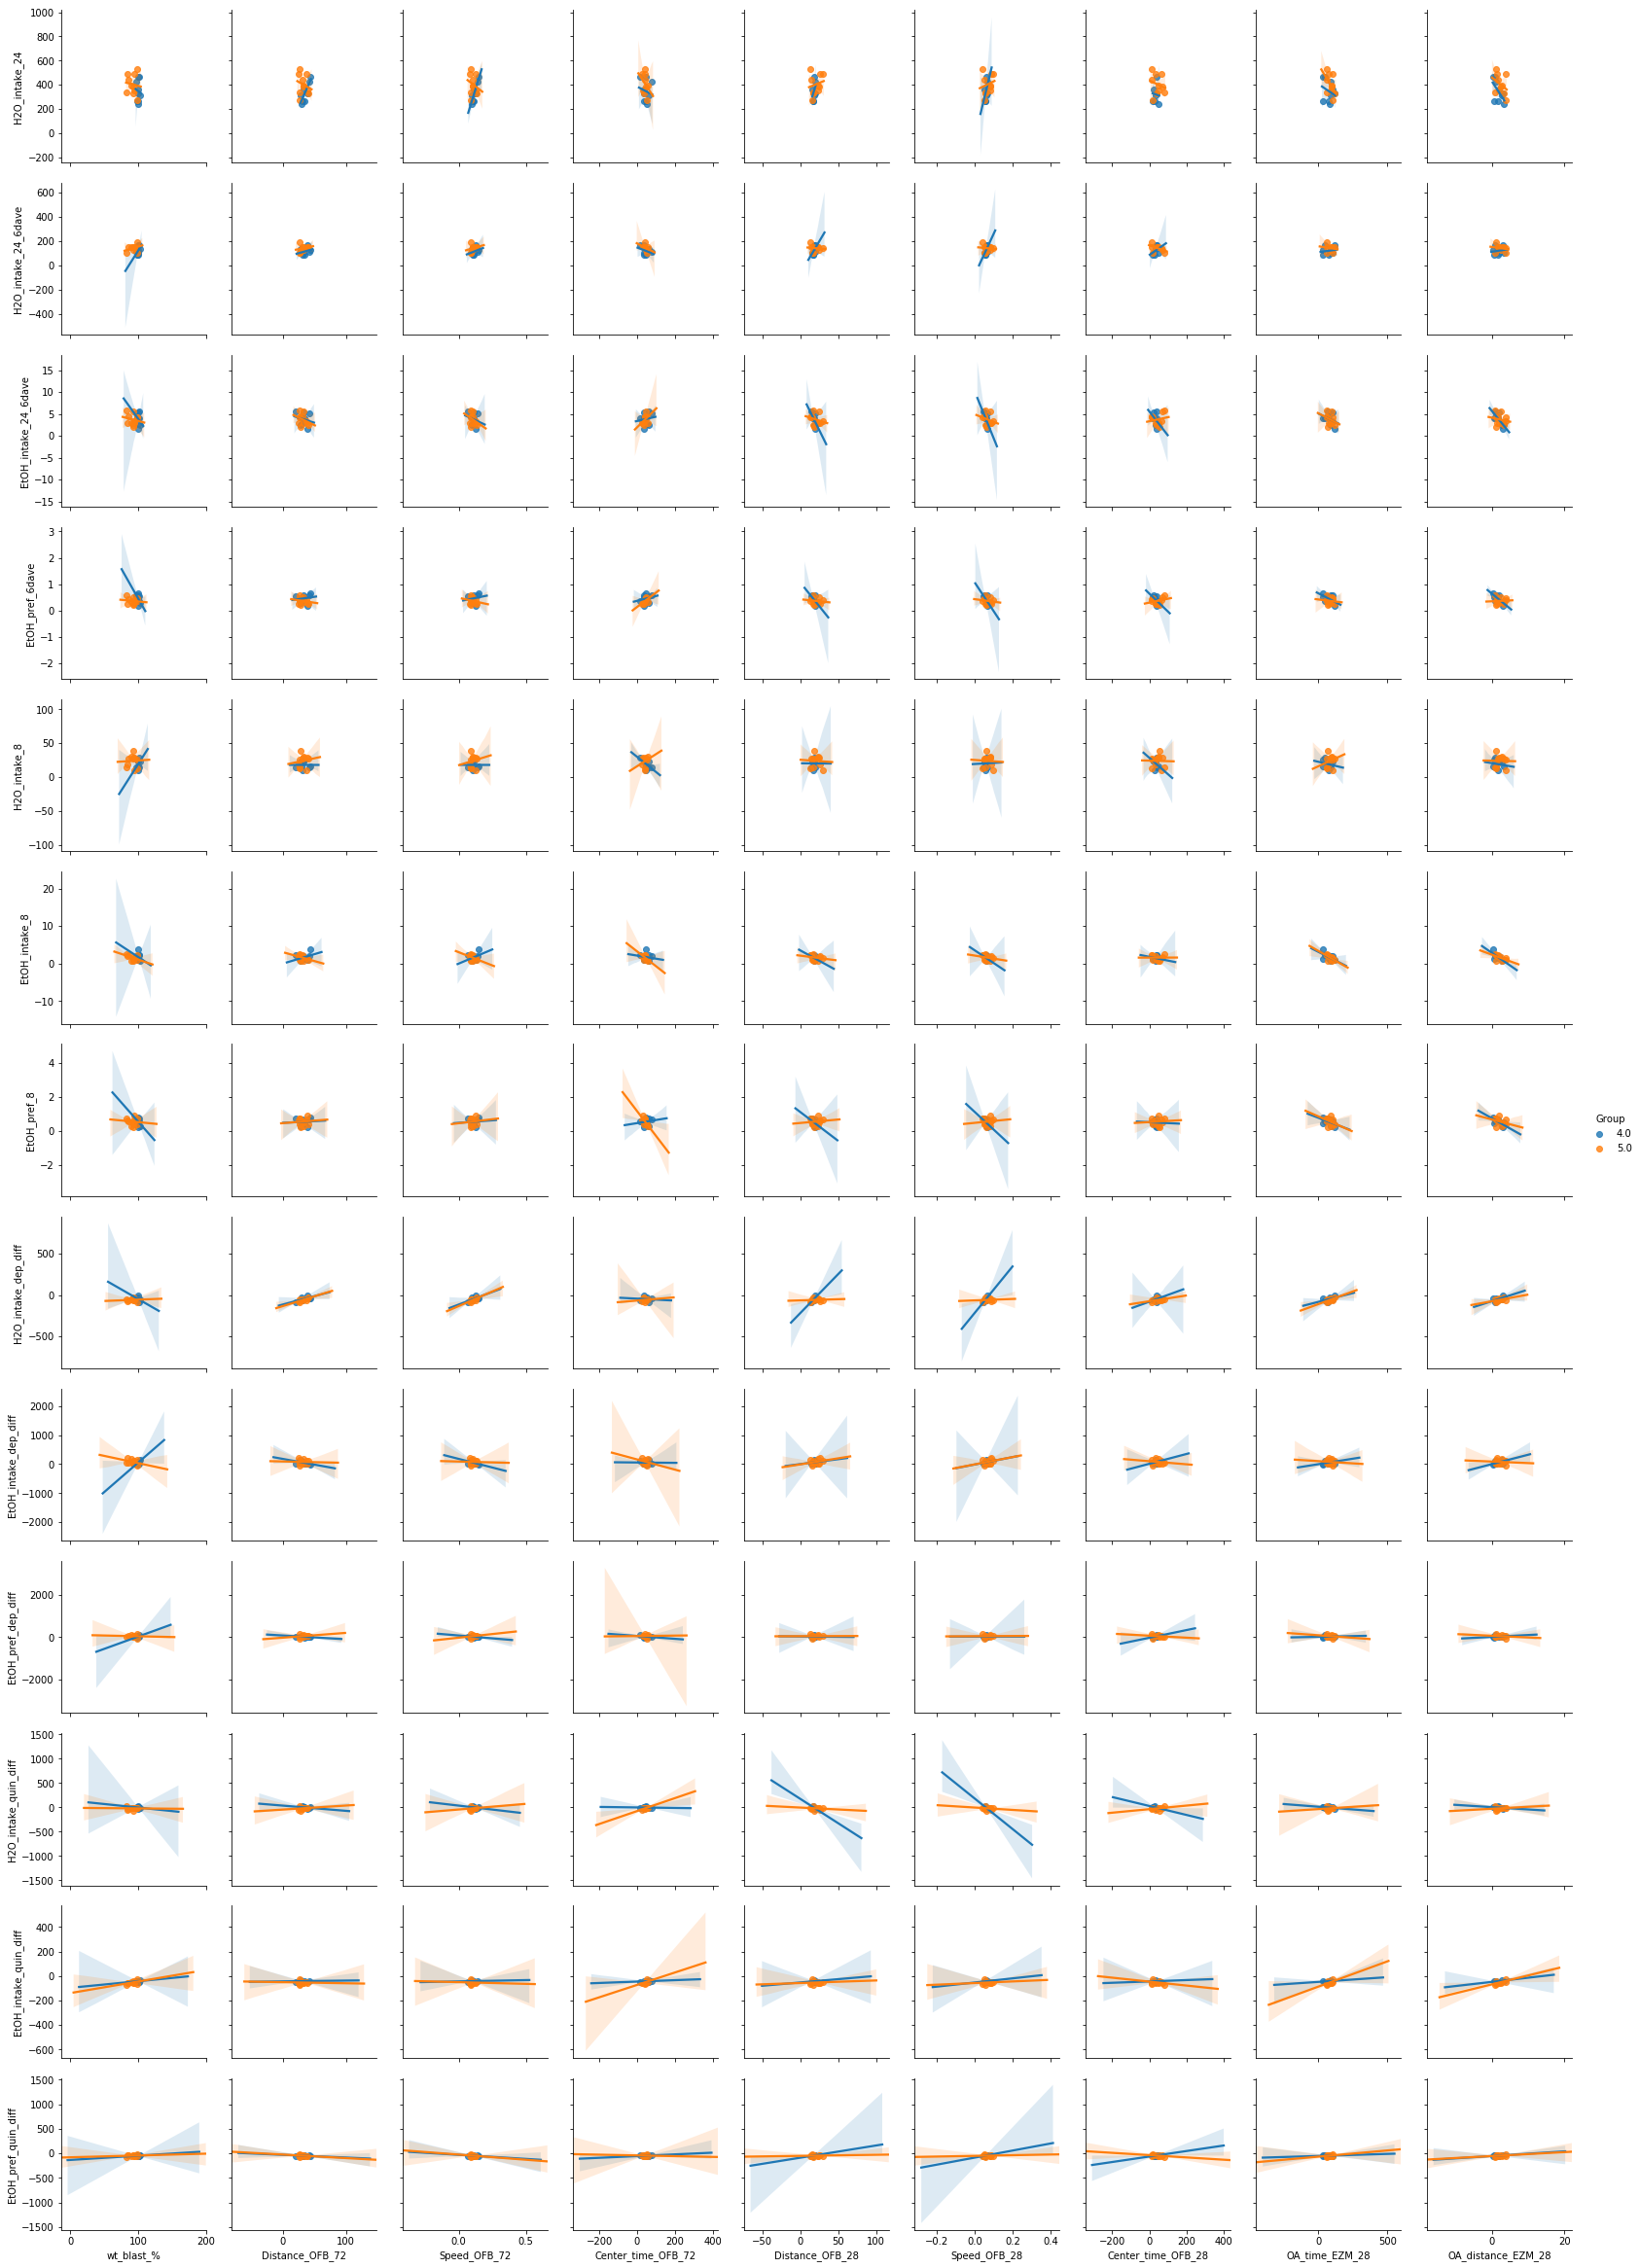

In [20]:
final_data_no_outliers.reset_index(inplace=True)
sns.pairplot(final_data_no_outliers, x_vars = behav_vars, y_vars = etoh_vars, hue='Group', kind = "reg")

In [21]:
corr_vars = ['Group', 'H2O_intake_24', 'H2O_intake_24_6dave', 'EtOH_intake_24_6dave', 'EtOH_pref_6dave', 'H2O_intake_8', 'EtOH_intake_8', 'EtOH_pref_8', 'H2O_intake_dep_diff', 'EtOH_intake_dep_diff', 'EtOH_pref_dep_diff', 'H2O_intake_quin_diff', 'EtOH_intake_quin_diff', 'EtOH_pref_quin_diff', 'wt_blast_%', 'Distance_OFB_72', 'Speed_OFB_72', 'Center_time_OFB_72', 'Distance_OFB_28', 'Speed_OFB_28', 'Center_time_OFB_28', 'OA_time_EZM_28', 'OA_distance_EZM_28']
corr = final_data_no_outliers[corr_vars].groupby(["Group"]).corr()
corr.to_csv('corr.csv')